In [133]:
import pandas as pd
import numpy as np
from scipy import stats as stats
from scipy import interpolate
import sklearn
from matplotlib import pyplot as plt
import regex
import statsmodels.api as sm
import pickle
from geopy.distance import geodesic
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

In [164]:
df=pd.read_pickle('Clean_Train.pkl')
with open('variable_org','rb') as f:
    variable_org=pickle.load(f)
    pass

target=variable_org['target']
dense_factors=variable_org['dense']
sparse_factors=variable_org['sparse']
category_factors=variable_org['categorical']
ordinal_factors=variable_org['ordinal']
other_factors=variable_org['other']

As a result of our data analysis, we want to create a dummy variable for houses in the zipcode 98039.

In [165]:
df['Medina']=df.zipcode.apply(lambda z:z==98039)
category_factors.append('Medina')

We also thought it would be interesting to consider the distance from downton Seattle, the city's financial and industrial center.  To measure this distance, we used the city's largest building, Columbia Center.

In [166]:
columbia_center_gps=(47.6049412,-122.3326903)

In [167]:
df['GPS']=df.apply(lambda r:(r.lat,r.long),axis=1)
df['Miles_to_Downtown']=df.GPS.apply(lambda g:geodesic(columbia_center_gps,g).miles)

In [168]:
df.Miles_to_Downtown.describe()

count    21467.000000
mean        11.449800
std          6.567140
min          0.639744
25%          6.100777
50%         10.286960
75%         15.668238
max         48.083211
Name: Miles_to_Downtown, dtype: float64

<AxesSubplot:ylabel='Frequency'>

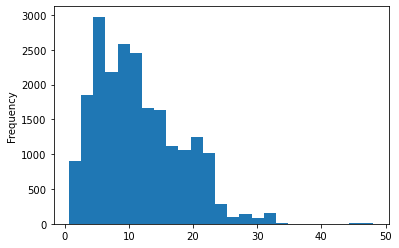

In [169]:
df.Miles_to_Downtown.plot.hist(bins=25)

<AxesSubplot:xlabel='Miles_to_Downtown', ylabel='price'>

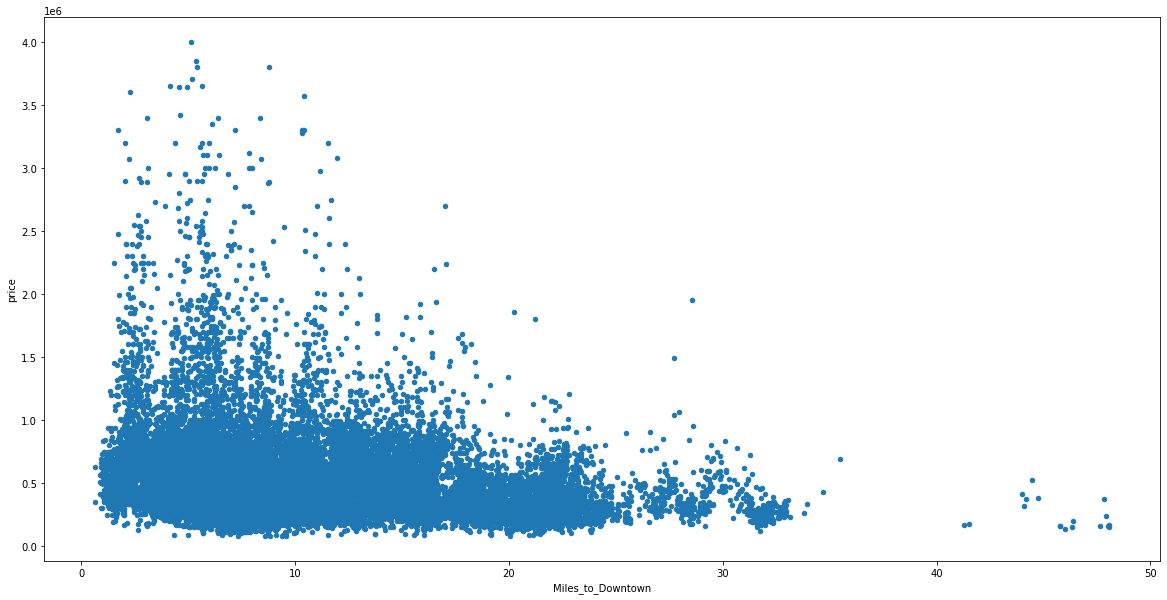

In [171]:
fig,ax=plt.subplots(figsize=(20,10))
df.plot.scatter(y='price',x='Miles_to_Downtown',ax=ax)

In [172]:
df[['price','Miles_to_Downtown']].corr()

,price,Miles_to_Downtown
price,1.000000,-0.296401
Miles_to_Downtown,-0.296401,1.000000


In [173]:
city_bound=7.5
print(df[df.Miles_to_Downtown<city_bound].price.mean())
print(df[df.Miles_to_Downtown>city_bound].price.mean())

660242.5510578279
476571.4506503443


In [187]:
cats_df.shape

(21467, 38)

Now, we want to consider polynomial values for square foot living and square foot outside

In [175]:
df['sqft_living2']=df['sqft_living']**2
dense_factors.append('sqft_living2')

We also will need to translate our categorical variables into dummy variables.

In [186]:
cats_df=df.copy()
dummies=[]
ohe = OneHotEncoder(drop='first')
for c in category_factors:
#cat='season'
    cat_trans = ohe.fit_transform(df[[c]])
    cols=[s.replace('x0',c) for s in ohe.get_feature_names()]
    cat_df = pd.DataFrame(cat_trans.todense(), columns=cols,index=df.index)
    cats_df=pd.merge(cats_df,cat_df,right_index=True,left_index=True,how='outer')
    dummies.extend(cols)

In [201]:
df=cats_df.copy()
print(df.shape)

(21467, 38)


Let's also scale our data.

In [202]:
ss=StandardScaler()
ss.fit(df[dense_factors])
#df_copy=pd.DataFrame(ss.transform(df[dense_factors]),columns=dense_factors,index=df.index)
df[dense_factors]=ss.transform(df[dense_factors])

,sqft_living,sqft_outside,percent_above,sqft_living15,sqft_outside15,age,sqft_living2
id,,,,,,,
71293005201410,-0.993164,-0.251448,0.728325,-0.942984,-0.261184,0.532979,-0.750932
64141001921412,0.550391,-0.244485,-0.181847,-0.431282,-0.187234,0.669147,0.300853
5631500400152,-1.448457,-0.087368,0.728325,1.074584,-0.214621,1.315950,-0.912256
24872008751412,-0.126997,-0.300741,-1.986749,-0.913744,-0.291413,0.192556,-0.256729
1954400510152,-0.437928,-0.184920,0.728325,-0.270461,-0.198333,-0.522330,-0.462385
...,...,...,...,...,...,...,...
263000018145,-0.604499,-0.419286,0.728325,-0.665203,-0.456592,-1.305301,-0.559543
6600060120152,0.261668,-0.284781,0.728325,-0.226601,-0.213358,-1.441470,0.044833
1523300141146,-1.170839,-0.394157,0.728325,-1.410826,-0.411113,-1.305301,-0.821959


Finally, we wish to save out our new dataframe and list of variables.

In [203]:
variable_types={
    'target':target,
    'dense':dense_factors,
    'sparse':sparse_factors,
    'categorical':category_factors,
    'ordinal':ordinal_factors,
    'other':other_factors,
    'dummies':dummies
}
with open('variable_org','wb') as f:
    pickle.dump(variable_types,f)
df.to_pickle('Final_Train.pkl')

In [148]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'sale_yr', 'sale_month', 'season', 'age',
       'last_renovation', 'renovation_status', 'sqft_outside',
       'sqft_outside15', 'percent_above', 'Medina', 'GPS', 'Miles_to_Downtown',
       'sqft_living2', 'season_Spring', 'season_Summer', 'season_Winter',
       'waterfront_1.0', 'Medina_True'],
      dtype='object')

In [149]:
df.shape

(42934, 38)

In [190]:
dummies

['season_Spring',
 'season_Summer',
 'season_Winter',
 'waterfront_1.0',
 'Medina_True']